In [124]:
# Carga de paquetes necesarios para graficar
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import math
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preámbulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [125]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

Vamos a juntar los museos con los barrios para luego relacionarlos y hacer mas amenos algunos gráficos y que quede mas representativo.

In [126]:
museos = museos.to_crs("EPSG:22184")
barrios = barrios.to_crs("EPSG:22184")

museos_con_barrios = gpd.sjoin(museos, barrios, how="left", predicate='within') #esto me junta todo

# Vamos a hacer el print para ver como se llama en 'museos' y en 'barrios' la columna correspondiente a su nombre, luego lo comentamos
# print(museos.columns)
# print(barrios.columns)

## Visualización

<Axes: >

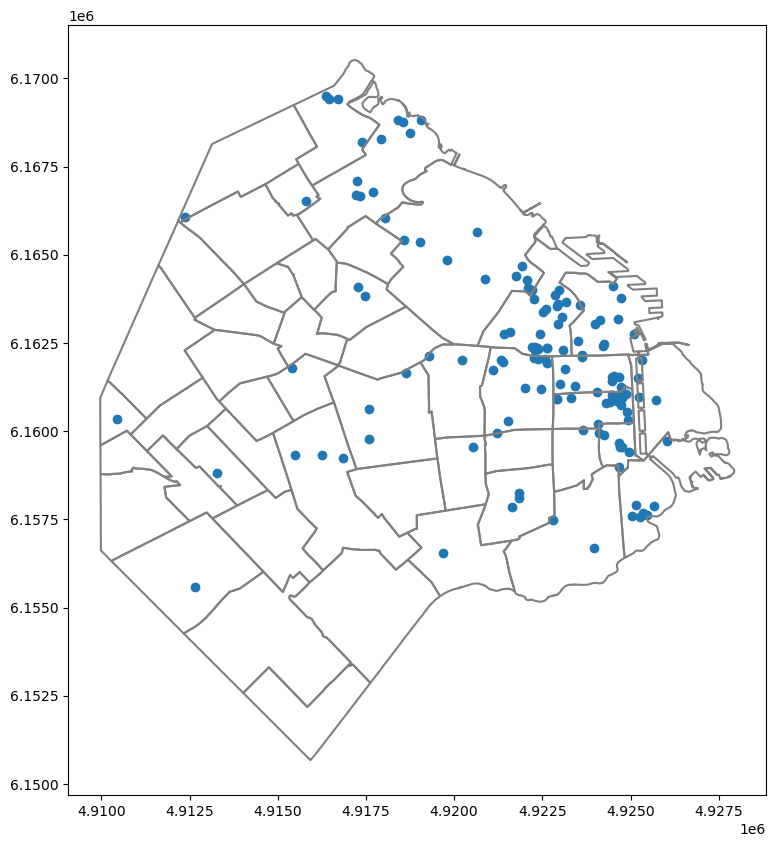

In [127]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [128]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [129]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [130]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

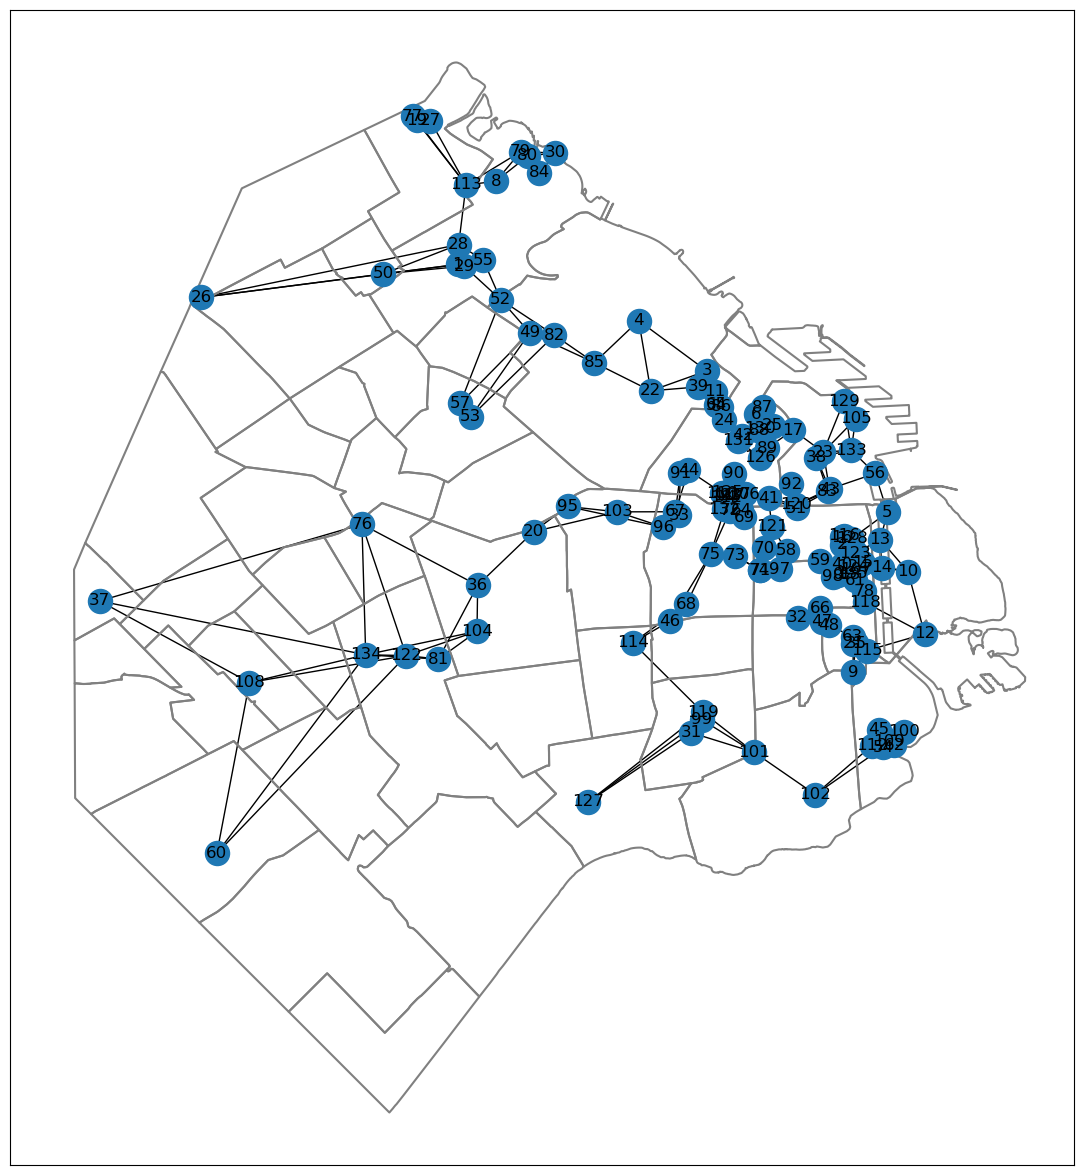

In [131]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de
\begin{equation*}
\textbf{p} = (1-α) C \textbf{p} + \frac{α}{N}1 \tag{3}
\end{equation*}
debemos mostrar que este vector de ranking es solución de $M\textbf{p} = b$, con $M = \frac{N}{α} (I - (1-α)C)$ y $b=1$.

Si reemplazamos M y b en la función, deberíamos llegar a la ecuación (3). Veamos:
\begin{align*}
\frac{N}{\alpha} (I - (1-\alpha)C) \cdot \textbf{p} &= 1 \\
{\scriptsize \text{paso multiplicando } \alpha \text{ y dividiendo } N} &\downarrow \\
(I - (1-\alpha)C) \cdot \textbf{p} &= \frac{\alpha}{N} \mathbf{1} \\
{\scriptsize \text{distribuimos } \textbf{p} \text{ en el paréntesis}} &\downarrow \\
\textbf{p} - (1-\alpha)C\textbf{p} &= \frac{\alpha}{N} \mathbf{1} \\
{\scriptsize \text{despejamos la } \textbf{p} \text{ que no está multiplicando a nada}} &\downarrow \\
\textbf{p} &= \frac{\alpha}{N} \mathbf{1} + (1-\alpha)C\textbf{p} \ \checkmark
\end{align*}
Bien, llegamos a la ecuación (3), que es lo que queríamos. Entonces, si el $\textbf{p}$ que cumple con $M\textbf{p}=b$ bajo los valores de $M$ y $b$ que aclaramos al principio es igual a la ecuación (3), podemos decir que el vector de ranking descrito es solución.

## Punto 2:


Para que exista una única solución del punto anterior, necesitamos que M sea una matriz inversible. Esto significa que el núcleo de M debe ser 0. Es decir:
\begin{equation*}
M \cdot x = 0 \iff x = 0
\end{equation*}

Recordemos cómo era M:
\begin{equation*}
M = \frac{N}{\alpha}(I - (1 - \alpha)\cdot C)
\end{equation*}

Vamos a probar que M es inversible por el absurdo. Entonces, asumimos que M es singular (no inversible). Por lo tanto podemos decir que existe un x distinto a 0 tal que:

\begin{equation*}
\frac{N}{\alpha}(I - (1 - \alpha)\cdot C)\cdot x = 0
\end{equation*}

Podemos pasar dividiendo $N/\alpha$ porque es un número: \\

\begin{equation*}
(I - (1 - \alpha)\cdot C)\cdot x = 0 \\
x - (1 - \alpha)\cdot C\cdot x = 0 \\
(1 - \alpha)\cdot C\cdot x = x
\end{equation*}

Por comodidad, llamamos B = (1 - $\alpha$)$\cdot$ C

\begin{equation*}
B\cdot x = x
\end{equation*}

Ahora bien, sabemos que $||C||_1 = 1$, pues es una matriz estocástica y todas sus columnas suman 1. Asimismo, $0 < \alpha < 1$, luego $0 < (1- \alpha) < 1$. Por lo tanto, $||(1- \alpha)\cdot C||_1 = (1- \alpha)\cdot ||C||_1 < 1$. Lo podemos reescribir diciendo $||B||_1 < 1$

Teniendo en cuenta todo esto, volvamos a nuestra ecuación, pero ahora apliquemos $||\cdot||_1$:

\begin{equation*}
||B||_1\cdot ||x||_1 = ||x||_1 \\
\end{equation*}

Ahora bien, por las propiedades de la norma operatoria, tenemos que:

\begin{equation*}
||B||_1 \cdot ||x||_1 \geq ||B\cdot x||_1 = ||x||_1
\end{equation*}\\

\begin{equation*}
||B||_1 \cdot ||x||_1 \geq ||x||_1 \\
\end{equation*}

Dado que $x \neq 0$, puedo dividir por $||x||_1$ en ambos lados:

\begin{equation*}
||B||_1 \geq 1 \\
\end{equation*}

Pero ya habíamos aclarado que $||B||_1 < 1 \Rightarrow $ ¡Absurdo! \\
Así probamos que, de hecho, M sí es inversible y su núcleo es trivial. Por lo tanto, dado que se cumplen las condiciones necesarias, el sistema del punto anterior tiene solución única.




# **Funciones del TP**

En esta sección incluiremos todas las funciones definidas en el archivo template_funciones y algunas funciones auxiliares extras que serán utiles para el desarrollo del trabajo práctico:

In [132]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

def calculaLU(matriz):
    # matriz es una matriz de NxN
    lista_de_triangulacion=[]
    U=matriz.copy()
    m=matriz.shape[0]
    n=matriz.shape[1]
    res=[]

    if m!=n:
        print('Matriz no cuadrada')
        return

    L = np.eye(n,n)
    for j in range (n):
        for i in range (j+1,n):
            coef= U[i][j] / U[j][j]
            L[i][j] = coef
            for k in range (n):
                U[i][k]= U[i][k] - (coef * U[j][k])

    res.append(L)
    res.append(U)
    return res

# Retorna la factorización LU a través de una lista con dos matrices L y U de NxN.
def calcular_transpuesta(M):
    m=M.shape[0]
    n=M.shape[1]
    L=np.eye(n,m)
    for i in range (m):
        for j in range (n):
            L[j][i]= M[i][j]
    return L

def calcular_inversa(A):  #calcula la inversa con la implementacion de LU
    dimA= A.shape[0]
    L,U=calculaLU(A)
    I=np.eye(dimA,dimA)
    primer_sistema= scipy.linalg.solve_triangular(L,I, lower=True)
    matriz_inversa= scipy.linalg.solve_triangular(U,primer_sistema,lower=False)
    return matriz_inversa

def calcula_matriz_C(A):
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C
    dimA=A.shape[0]
    for i in range(dimA):
        A[i][i] = 0

    Kinv = np.zeros((dimA, dimA))


    for i in range(dimA):
        suma = 0
        for j in range(dimA):
            suma += A[i][j]
        if suma > 0:
            Kinv[i][i] = 1 / suma
    C = A.T @ Kinv
    return C


def calcula_pagerank(A,alfa):
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el número de museos N a partir de la estructura de la matriz A
    M = (N/alfa)*(np.eye(N) - (1-alfa)*C) #primera parte de la ecuacion del pagerank

    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d
    b = np.ones(N) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    # suma =np.sum(p)
    # res = p/suma
    return p

def calcula_matriz_C_continua(D):
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versión continua
    copiaD=D.copy()
    F = 1/copiaD
    np.fill_diagonal(F,0)
    dimD=copiaD.shape[0]

    Kinv=np.zeros((dimD,dimD)) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de F

    for i in range (dimD):
        total_fila=0
        for j in range (dimD):
            total_fila+=F[i][j]
        Kinv[i][i]= 1 / total_fila

    C = F @ Kinv  # Calcula C multiplicando Kinv y F
    return C

def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    C_potencia = np.eye(C.shape[0])
    B = np.eye(C.shape[0])
    if cantidad_de_visitas == 1:
        B += C

    for i in range(1,cantidad_de_visitas):
        # Sumamos las matrices de transición para cada cantidad de pasos
        C_potencia = C_potencia @ C  # Multiplicamos una vez por C cada vuelta
        B += C_potencia  # Sumamos la nueva potencia
    return B

def calculaV(B,W):
    L,U = calculaLU(B)
    Up = scipy.linalg.solve_triangular(L,W,lower=True) # Primera inversión usando L
    v = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    return v

def calcNorma(v):
    norma=0
    for elem in v:
        norma+=elem
    return norma

## **Función para los gráficos del punto 3:**

In [133]:
def graficos(p_x, barrios, G, G_layout,axs):
  # Toma la posicion del grafico en el subplot
  factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles # Visualización de la red en el mapa
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=axs) # Graficamos Los barrios
  pr = np.array(p_x)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
  pr = pr/pr.sum() # Normalizamos para que sume 1

  node_color=pr
  cmap = plt.cm.spring # Elegimos una escala de color para los nodos así queda mas visual y estético

  Nprincipales = 3 # Cantidad de principales
  principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
  labels = {n: str(n) for n in G.nodes} # Nombres para esos nodos

  nodes = nx.draw_networkx_nodes(G,G_layout,node_size=pr * factor_escala,node_color=node_color,cmap=cmap,ax=axs)
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(pr), vmax=max(pr)))
  sm.set_array([])
  plt.colorbar(sm, ax=axs, label="PageRank")

  nx.draw_networkx_edges(G, G_layout, ax=axs)
  nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=5, font_color="k", ax=axs);

## Punto 3:

a)
Calculamos el pagerank para m = 3 pasos con nuestras funciones y α = 1/5\
El gráfico contiene la red de museos con tamaño y color variable según su valor de pagerank y cada museo se encuentra con su número de índice

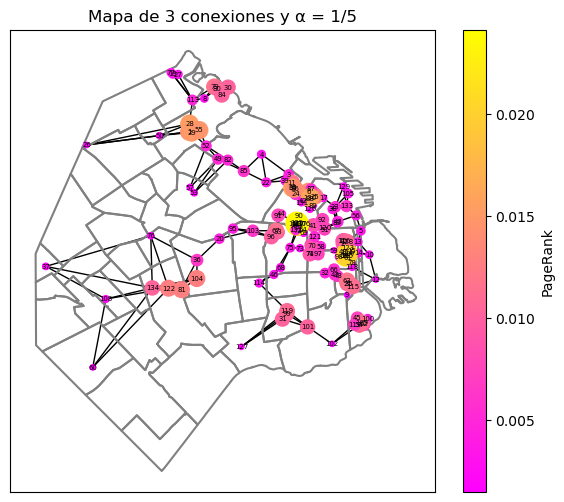

In [134]:
G = nx.from_numpy_array(A)
m=3
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
A = construye_adyacencia(D,m)

pr_a = calcula_pagerank(A,1/5)  # m = 3
#print(pr_a)

#dejamos comentado el print del pagerank para una mejor visualización del punto
fig, axs = plt.subplots(figsize=(7, 6))
graficos(pr_a, barrios, G, G_layout,axs)
plt.title(F"Mapa de {m} conexiones y α = 1/5");

b)Calculamos los pageranks para los distintos valores de M mediante la funcion obtener_pr_por_m y luego graficamos las distintas versiones  al variar M usando la funcion graficos_pr_b

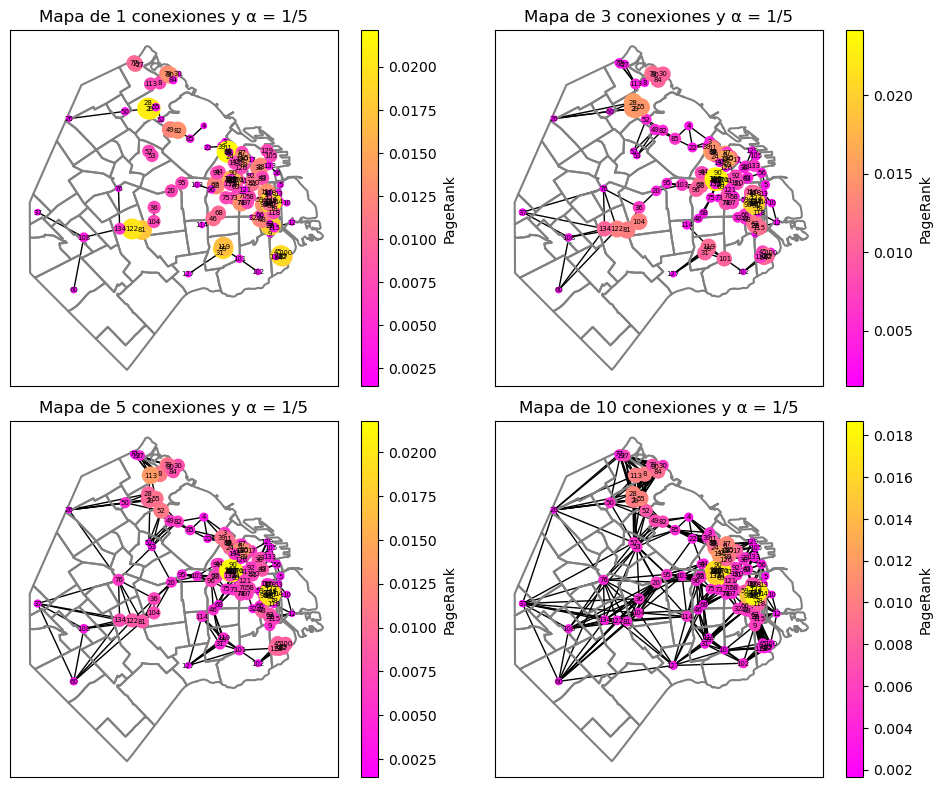

In [135]:
#b)
def obtener_pr_por_m(D, valores_m, alfa):
    pr_b = []
    for m in valores_m:
        A = construye_adyacencia(D, m)
        pr = calcula_pagerank(A, alfa)
        pr_b.append(pr)
    return pr_b

valores_m = [1, 3, 5, 10]
pr_b = obtener_pr_por_m(D, valores_m, 1/5)  # Obtenemos el PageRank para cada valor de m


def graficos_pr_b(pr_b, D, valores_m, axs):
    for i, pr in enumerate(pr_b):
        A = construye_adyacencia(D, valores_m[i])
        G = nx.from_numpy_array(A)
        G_layout = {i: v for i, v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'], museos.to_crs("EPSG:22184").get_coordinates()['y']))}
        graficos(pr, barrios, G, G_layout, axs[i])
        axs[i].set_title(F"Mapa de {valores_m[i]} conexiones y α = 1/5");

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) #creo la grilla del subplot
axs = axs.flatten() #convierto la grilla en una lista de las posiciones

graficos_pr_b(pr_b, D, valores_m, axs)

plt.tight_layout()
# el orden en el que aparecen los mapas respeta el orden de la lista valores_m
# el 1° mapa corresponde a m = 1, el 2° a m = 3, etc.

Vemos que cuando existen pocas conexiones, se forman sub grafos, en los cuales el museo de mas visita toma mucha relevancia en el pagerank, mientras que al subir las conexiones y armar una red mas grande, los museos mas grandes opacan a los grandes de redes mas divididas.

c) De forma similar que en el subindice b), definimos dos funciones: una para calcular el pagerank a partir de una lista de α, y otra para graficar dichos pageranks

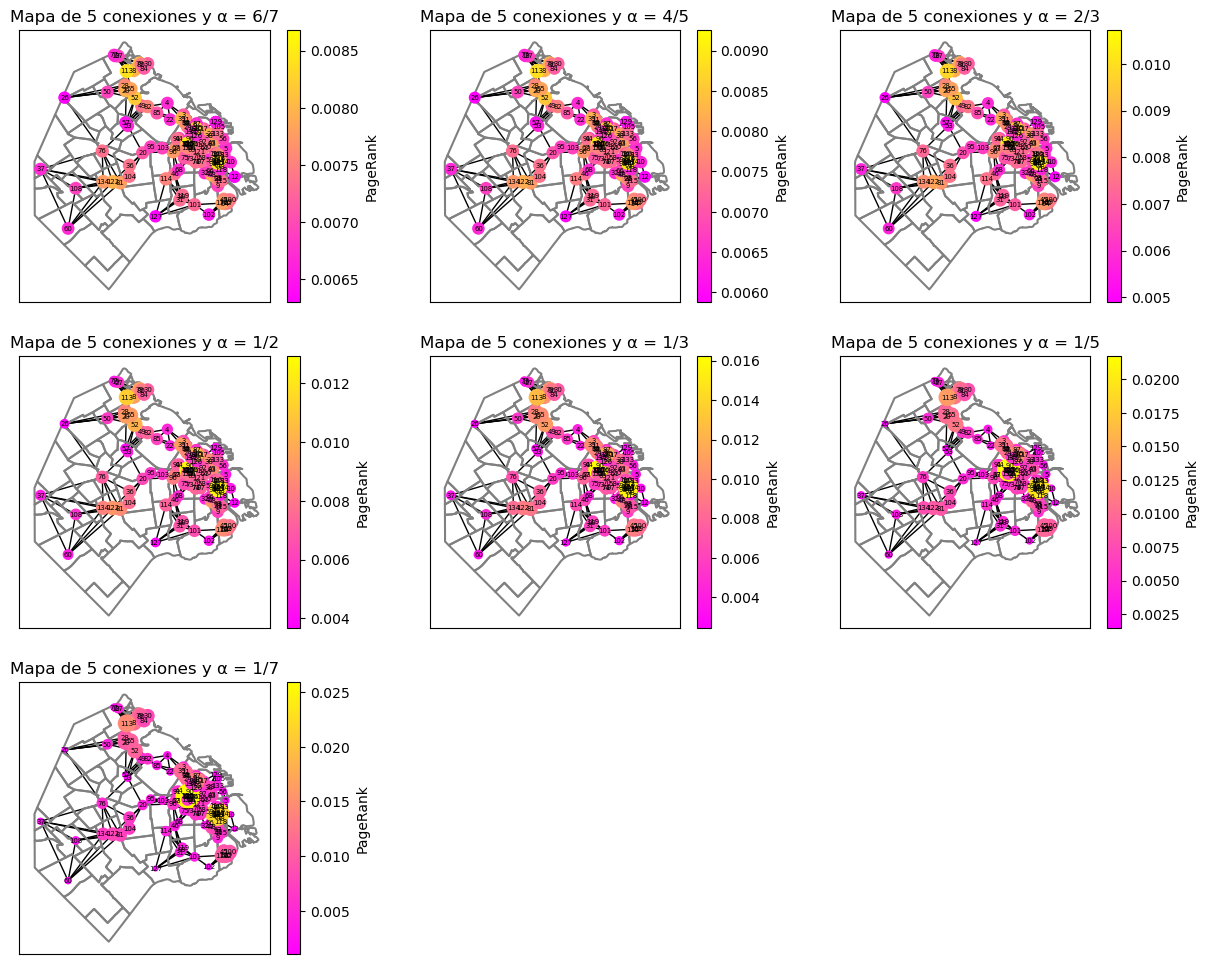

In [136]:
#c)
def obtener_pr_por_alfa(D,valores_alfa,m):
  pr_c = []
  for alfa in valores_alfa:
    pr = calcula_pagerank(A, alfa)
    pr_c.append(pr)
  return pr_c

m = 5
A = construye_adyacencia(D, m)
valores_alfa = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
pr_c = obtener_pr_por_alfa(D,valores_alfa,m)

valores_alfa_str = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"] # creamos esto solo para usarlo en los titulos de los graficos y que no lo convierta a un float

def graficos_pr_c(pr_c,axs):
  G = nx.from_numpy_array(A)
  i = 0
  for pr in pr_c:
    graficos(pr, barrios, G, G_layout,axs[i])
    axs[i].set_title(F"Mapa de 5 conexiones y α = {valores_alfa_str[i]}")
    i+=1;
  for j in range(len(pr_c), len(axs)):
        axs[j].axis("off")

fig, axs = plt.subplots(3, 3, figsize=(15, 12)) #creo la grilla del subplot
axs = axs.flatten() #convierto la grilla en una lista de las posiciones

graficos_pr_c(pr_c,axs)
# el orden en el que aparecen los mapas respeta el orden de la lista valores_alfa
# el 1° mapa corresponde a alfa = 6/7, el 2° a alfa = 4/5, etc.

Con un Alpha bajo observamos que es mas probable que se respete el flujo de la red y no se produzcan saltos "al azar" a museos que no se encuentran conectados con el museo anterior, haciendo que museos con mal pagerank no sumen importancia.

## Usando los valores de p obtenidos para cada caso:

a.2) y b.2) Comenzamos señalando cuales son los índices de los museos con mayor pagerank en cada caso especificado:


*   M = 3 y α = 1/5
*   M variable y α = 1/5
*   M = 5 y α variable


In [137]:
# a.2)  3 museos mas centrales (para cada m y cada α)
# usamos argsort que te da un array con las posiciones que tendría que tener cada elemento para que el arreglo quede ordenado
mas_centrales_a = np.argsort(pr_a)[-3:]
print("Los indices de los tres museos con mayor pagerank con m=3 y α=1/5 son:", mas_centrales_a)

mas_centrales_b = [np.argsort(pr)[-3:] for pr in pr_b]
print("Los indices de los tres museos con mayor pagerank con m variable y α=1/5 son:", mas_centrales_b, "para cada m, que sigue el orden de la lista valores_m = [1, 3, 5, 10]")

mas_centrales_c = [np.argsort(pr)[-3:] for pr in pr_c]
print("Los indices de los tres museos con mayor pagerank con m=5 y α variable son:", mas_centrales_c, "para cada α, que sigue el orden de la lista valores_alfa = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]")

Los indices de los tres museos con mayor pagerank con m=3 y α=1/5 son: [ 18 125 117]
Los indices de los tres museos con mayor pagerank con m variable y α=1/5 son: [array([ 34, 107,  65], dtype=int64), array([ 18, 125, 117], dtype=int64), array([117, 125,  93], dtype=int64), array([ 15, 135, 124], dtype=int64)] para cada m, que sigue el orden de la lista valores_m = [1, 3, 5, 10]
Los indices de los tres museos con mayor pagerank con m=5 y α variable son: [array([ 18, 135, 107], dtype=int64), array([ 18, 135, 107], dtype=int64), array([ 18, 135, 107], dtype=int64), array([135,  93, 107], dtype=int64), array([107, 125,  93], dtype=int64), array([117, 125,  93], dtype=int64), array([117, 125,  93], dtype=int64)] para cada α, que sigue el orden de la lista valores_alfa = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]


Realizamos el gráfico para el conjunto de M variables.
Tomamos los indices de los top 3 museos de cada instancia, sacamos repetidos, y graficamos la evolución de los mismos al aumentar la M

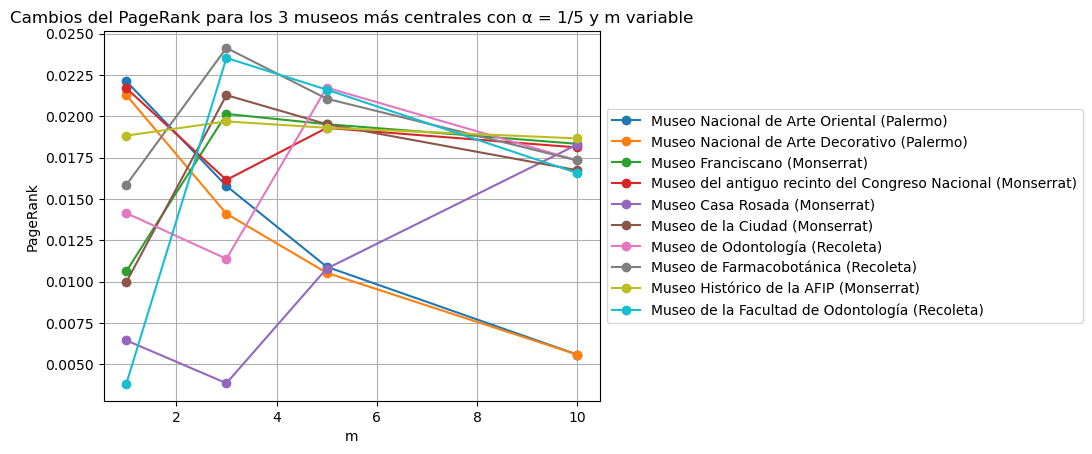

In [138]:
# ploteo de los 3 mas centrales de b (con alfa fijo y m variable)
# veremos como se comporta el PageRank en función de m con alfa = 1/5
lista = []

for i in range(len(valores_m)):
    top_3_centrales = np.argsort(pr_b[i])[-3:] # buscamos los indices de los 3 museos con mayor PageRank para cada m
    lista.append(top_3_centrales)

# creamos un conj para quedarnos con los ids de los museos que aparecieron entre los mejores
todos_los_indices = []
for top3 in lista:
    for indice in top3:
        todos_los_indices.append(indice)
top_3_indices = set(todos_los_indices) # juntamos todos en un conjunto para evitar los repetidos

plt.figure()

for museo_id in top_3_indices:
    y = [pr[museo_id] for pr in pr_b]
    nombre_m = museos_con_barrios.iloc[museo_id]["name"]
    barrio_m = museos_con_barrios.iloc[museo_id]["nombre"]
    plt.plot(valores_m, y, marker='o', label=f"{nombre_m} ({barrio_m})")

plt.xlabel("m")
plt.ylabel("PageRank")
plt.title("Cambios del PageRank para los 3 museos más centrales con α = 1/5 y m variable")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

Ahora graficamos para el conjunto de α variables.
Tomamos los indices de los top 3 museos de cada instancia, sacamos repetidos, y graficamos la evolución de los mismos al aumentar el α

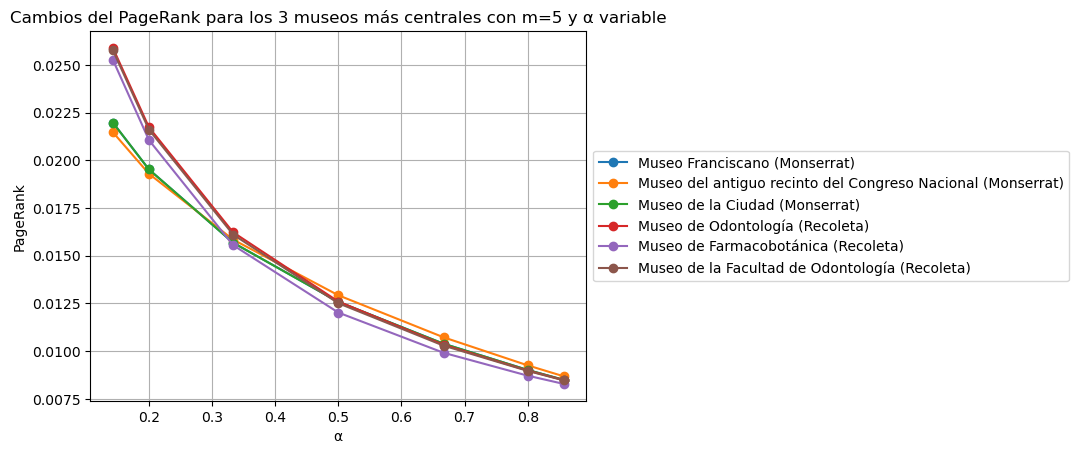

In [139]:
# ploteo de los 3 mas centrales de c (con m fijo y alfa variable)
# veremos como se comporta el PageRank en función de alfa con m = 5
lista = []

for i in range(len(valores_alfa)):
    top_3_centrales = np.argsort(pr_c[i])[-3:] # buscamos los indices de los 3 museos con mayor PageRank para cada alfa
    lista.append(top_3_centrales)

# creamos un conj para quedarnos con los ids de los museos que aparecieron entre los mejores
todos_los_indices = []
for top3 in lista:
    for indice in top3:
        todos_los_indices.append(indice)
top_3_indices = set(todos_los_indices) # juntamos todos en un conjunto para evitar los repetidos

plt.figure()

for museo_id in top_3_indices:
    y = [pr[museo_id] for pr in pr_c]
    nombre_m = museos_con_barrios.iloc[museo_id]["name"]
    barrio_m = museos_con_barrios.iloc[museo_id]["nombre"]
    plt.plot(valores_alfa, y, marker='o', label=f"{nombre_m} ({barrio_m})")

plt.xlabel("α")
plt.ylabel("PageRank")
plt.title("Cambios del PageRank para los 3 museos más centrales con m=5 y α variable")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

 Analizando la evolución del pagerank al variar por un lado los M y por el otro los α podemos observar los siguientes patrones:


Variación del M:

Aumentar el valor de M favorece a los museos de las áreas de mayor densidad. Al tener áreas con tanta concentración de museos y muchas conexiones entre ellos, es más probable que sean visitados y aumente su pagerank.
Los barrios que se benefician de este aumento de M son principalmente los de Monserrat y Recoleta, mientras que los museos de Palermo decrecen sus pageranks al aumentar el M, pasando de los más altos a los más bajos.

Variación del α:

Al aumentar el valor de α, podemos observar como los museos que se encuentran en la zona de mayor densidad pierden valor en el pagerank. Esto sucede debido a que, al aumentar α, la probabilidad de un visitante de seguir el camino de la red en la que se encuentra su museo actual baja, provocando que museos que se encuentran en zonas céntricas pierdan relevancia y aumenten los del cordón externo. Es una tendencia que podemos observar en el último gráfico.

Al aumentar α vemos que no varía demasiado la diferencia de pagerank entre los museos pero el valor absoluto de los mismos es considerablemente menor.

Los barrios de los museos de mayor pagerank son siempre Monserrat y Recoleta.

## Punto 4:

Queremos probar que:
\begin{equation*}
v = B^{-1} \cdot w
\end{equation*}
donde $v$ es el vector que representa las visitas iniciales y $w$ el que representa las visitas totales de cada museo.

Además, por consigna, sabemos que:
\begin{equation*}
B = \sum_{k=0}^{r-1}C^k = C^0 + C^1 + ... + C^{r-1}
\end{equation*}
y que podemos asumirla como inversible.

Entonces, partiendo de que $v = B^{-1} \cdot w$, podemos considerar $B \cdot v = w$. Veamos qué pasa con esta ecuación para distintas C:  
$\bullet\ C^0 \cdot v = w_{0} ⇔ v=w_{0}$ = visitas totales en el paso 0 (el incial)  
$\bullet\ C^1 \cdot v = w_{1} ⇔ v=w_{1}$ = visitas totales en el paso 1  
$\bullet\ \dotsb$  
$\bullet\ C^{r-1} \cdot v = w_{r-1} ⇔ v=w_{r-1}$ = visitas totales en el paso $r-1$

Si tomamos sumatoria a ambos lados de la última ecuación tenemos que:
\begin{align*}
(\sum_{k=0}^{r-1}C^{k}) \cdot v = \sum_{k=0}^{r-1}w_{k}
\end{align*}

Sin embargo, sabemos que $B = \sum_{k=0}^{r-1}C^k$ y que $\sum_{k=0}^{r-1}w_{k}$ es la sumatoria de los totales intermedios de visitas a cada museo, por lo que el resultado de la misma nos da el total global.

Entonces, podemos concluir lo siguiente:  
$\underbrace{(\sum_{k=0}^{r-1}C^{k})}_B  \cdot  v = \underbrace{\sum_{k=0}^{r-1}w_{k}}_w ⇒ B \cdot v=w ⇒ v = B^{-1}  \cdot  w \ \checkmark $  
que es a lo queríamos llegar.

## Punto 5:

Para calcular la cantidad de visitantes iniciales, necesitamos sumar todos los visitantes que comenzaron en cada museo, lo cual equivale a encontrar $ \|v\|_1$
Partiendo de:
\begin{equation*}
v = B^{-1} \cdot w
\end{equation*}
Resolvemos el sistema utilizando la factorización LU y calculamos $ \|v\|_1$

Finalmente, en el gráfico se representa la distribución por museo de los visitantes iniciales

C:\Users\camil\AppData\Local\Temp\ipykernel_11424\3855884097.py:98: RuntimeWarning: divide by zero encountered in divide
  F = 1/copiaD


La cantidad total de visitantes que entraron en la red es: 136604.99999999997
Y el grafico que representa a v es:


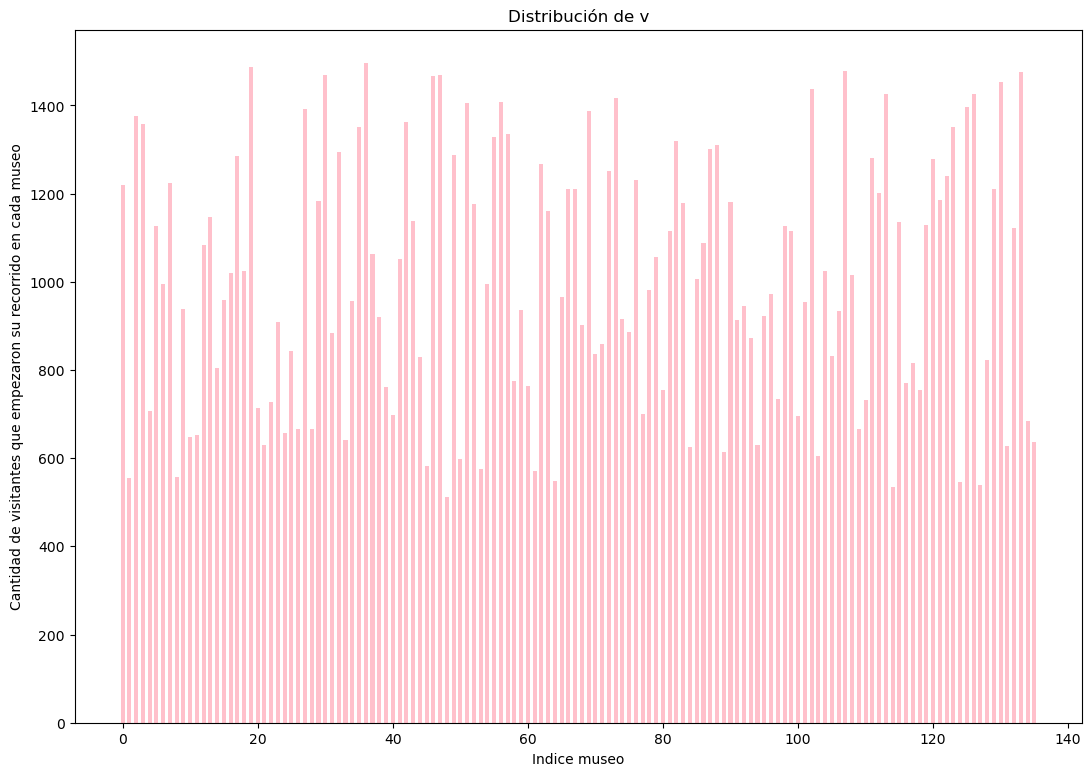

In [140]:
C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)

# abrimos el archivo de visitas y armamos nuestro vector w
with open("visitas.txt", "r") as file:
    w = np.array([float(line.strip()) for line in file])

w_vector = w.reshape(-1,1)

L, U = calculaLU(B)

# queremos resolver Bv = w
#B = LU
#LUv = w

# de acá sacamos que:
#a) Uv = y
#b) Ly = w

#Resolviendo ambos sistemas podemos obtener v.
y = scipy.linalg.solve_triangular(L, w_vector, lower=True)
v = scipy.linalg.solve_triangular(U, y)

#Ahora calculamos ||v||_1:
total = 0
for i in v:
    total += abs(i[0])

print("La cantidad total de visitantes que entraron en la red es:",total)

print("Y el grafico que representa a v es:")
# creamos un grafico de barras para facilitar la visualización de v con matplotlib.pyplot.bar(x, height, color: )
plt.figure(figsize=(13, 9)) #lo agrandamos así se nota mas la separacion de las barras
plt.bar(range(len(v)), v.flatten(), color='pink', width=0.6) #con width=0.6 hacemos las barras mas finitas
plt.title('Distribución de v')
plt.xlabel('Indice museo')
plt.ylabel('Cantidad de visitantes que empezaron su recorrido en cada museo')
plt.show()

Podemos observar que minimamente empiezan 500 personas en cada museo de nuestra red y la cantidad de visitantes iniciales de todos los museos se encuentran dentro del rango de 500 a 1500 personas

## Punto 6:

Comenzamos buscando el numero de condicion de la matriz B para ello sabemos que:
$$\text{cond}_1(B) = \|B\|_1 \cdot \|B^{-1}\|_1$$
Usando las funciones implementadas podemos calcularlo de la siguiente forma:


In [141]:
def calcular_norma1(B):
  dimB=len(B)
  norma=0
  for j in range (dimB):
    columna=0
    for i in range (dimB):
      columna+=abs(B[i][j])
    if columna>norma:
      norma=columna
  return norma

In [142]:
#buscamos obtener el numero de condicion de B con norma 1, si bien ya existe una funcion dentro de np, vamos a implementarlo
def calcular_norma1(B):
  dimB=len(B)
  norma=0
  for j in range (dimB):
    columna=0
    for i in range (dimB):
      columna+=abs(B[i][j])
    if columna>norma:
      norma=columna
  return norma

inversaB = calcular_inversa(B)
numero_de_condicion = calcular_norma1(B)*calcular_norma1(inversaB)
print("El numero de condicion es:",numero_de_condicion)

#De esta forma calculamos el numero de condicion de B

El numero de condicion es: 5.051771176665004


Para el calculo de la cota partimos de la siguiente ecuacion:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq \text{cond}_1(B) \cdot \frac{\|w - \tilde{w}\|_1}{\|w\|_1}
$$

Sabemos que w presenta un error de 5% y que $\text{cond}(b)_1 =$ numero_de_condicion  , por lo que basta reemplazar estos dos valores en la ecuacion y resolver:


In [143]:
# basta con multiplicar el numero de condicion por el error

cota_sup = numero_de_condicion * 0.05
print("La cota superior es:",cota_sup)


La cota superior es: 0.2525885588332502


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, '5'),
 6: Text(4922856.100832731, 6163868.567721188, '6'),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

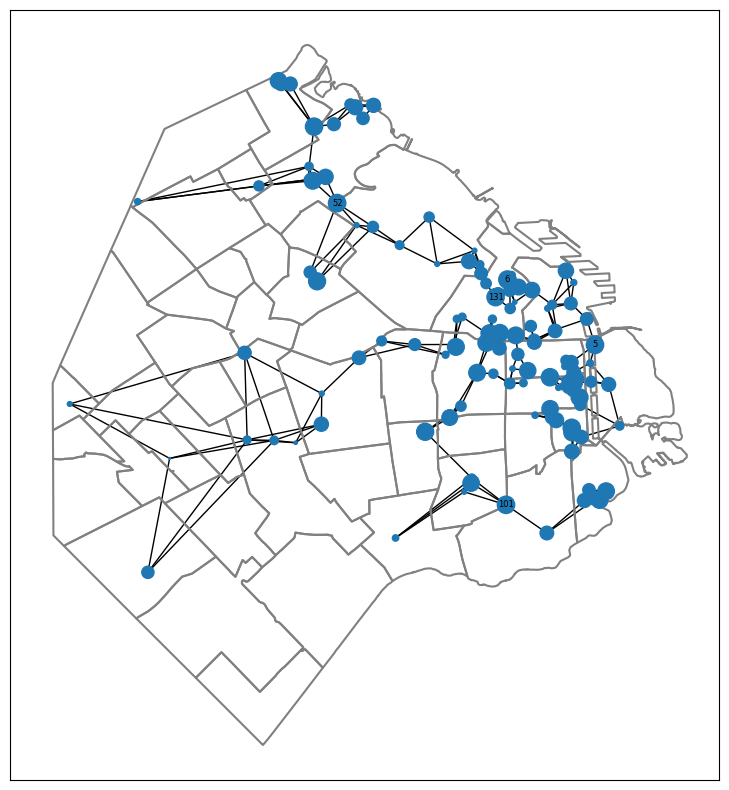

In [144]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

### ***TP 2***

### **PUNTO 1**

#### *SECCION A*

Recordemos que si $A$ es una matriz y $v$ un autovector asociado a un autovalor  $\lambda$, entonces $Av = \lambda v$  
Empecemos con $L$. Supongamos que $1$ es autovector de $L$, por lo tanto, podemos escribir:

\begin{equation*}
L \cdot 1 = \lambda \cdot 1
\end{equation*}  
Pero $L$ = $K - A$, entonces tenemos que:
\begin{equation*}
L \cdot 1 = (K - A) \cdot 1 = K \cdot 1 - A \cdot 1
\end{equation*}  

Pero fijemonos que al multiplicar a una matriz por un vector de unos, estamos armando un vector $v$ donde cada $v_i$ es la suma de los elementos de la fila $i$ de la matriz. Por lo tanto, $A\cdot 1$ nos da el vector de grados.  
Asimismo, recordemos que $K$ es la matriz diagonal de grado, es decir, que en los elementos de su diagonal tiene la suma de los elementos de las filas de $A$. De modo que cuando hacemos $K\cdot 1$ nos da, al igual que con $A$, el vector de grados. Entonces vemos que $A\cdot 1$ = $K\cdot 1$  
Finalmente:

\begin{equation*}
K \cdot 1 - A \cdot 1 = 0
\end{equation*}

Y nos queda:
\begin{equation*}
L \cdot 1 = 0
\end{equation*}

Pero $L \cdot 1 = \lambda \cdot 1$, entonces $\lambda \cdot 1 = 0$. Y esto solo sucede si $\lambda = 0$  
De esta manera, probamos que el vector de unos $1$ efectivamente es autovector de $L$ y su autovalor asociado es 0.  
   
Ahora veamos qué pasa con $R$. Recordemos que $R = A -P$, donde $A$ es la matriz de adyacencia y $P_{ij}$ = $\frac{k_i k_j}{2E}$  
Si suponemos nuevamente que $1$ es autovector de $R$, por lo tanto, podemos escribir:

\begin{equation*}
R \cdot 1 = \lambda \cdot 1
\end{equation*}  

Pero $R$ = $A - P$, entonces tenemos que:
\begin{equation*}
R \cdot 1 = (A - P) \cdot 1 = A \cdot 1 - P \cdot 1
\end{equation*}  

Ya sabemos que $A \cdot 1$ es el vector de grados. Veamos qué sucede con $P \cdot 1$.  
Echemos un vistazo a la fila $i$ de $P \cdot 1$, es decir, $(P \cdot 1)_i$: Sabemos que es la suma de los elementos de la fila $i$ de $P$. Por lo tanto, podemos escribirlo de la siguiente forma:  

\begin{equation*}
 (P \cdot 1)_i = \sum_{j=1}^{N}\frac{k_i k_j}{2E}
\end{equation*}  

Como estamos dejando a $i$ constante, entonces $k_i$ también es constante, al igual que $2E$, que es un número. Por lo tanto podemos pasar esa parte afuera de la sumatoria:

\begin{equation*}
 (P \cdot 1)_i = \frac{k_i}{2E}\sum_{j=1}^{N}k_j
\end{equation*}  

Pero, si lo pensamos, $\sum_{j}k_j$ es la suma de los grados de $A$, lo que equivale a la suma total de los elementos de $A$. Esto, a su vez, es igual a $2E$, puesto que $E$ es la suma de las conexiones *reales* de los nodos, y se lo multiplica por dos porque la red no es dirigida, entonces cada conexión real es contada dos veces en la matriz. Es decir:

\begin{equation*}
 \sum_{j=1}^{N}k_j = \sum_{i=1}^{N}\sum_{j=1}^{N}A_{ij} = 2E
\end{equation*}  

Así, nos queda:
\begin{equation*}
 (P \cdot 1)_i = \frac{k_i}{2E}2E
\end{equation*}  

Los $2E$ se cancelan y termina quedando
\begin{equation*}
 (P \cdot 1)_i = k_i
\end{equation*}  

Esto quiere decir que $P \cdot 1 = A \cdot 1 = k$, siendo $k$ el vector de grados. Nos termina quedando:
\begin{equation*}
A \cdot 1 - P \cdot 1 = 0
\end{equation*}

Por lo tanto:
\begin{equation*}
R \cdot 1 = 0
\end{equation*}

Pero $R \cdot 1 = \lambda \cdot 1$, entonces $\lambda \cdot 1 = 0$. Y, como con la matriz $L$, esto solo sucede si $\lambda = 0$  
Ahora sí, probamos que el vector de unos $1$  es autovector de $L$ y de $R$ y su autovalor asociado es 0.  

#### *SECCION B*

Tomando la sugerencia del ejercicio, tomemos a $M$ como matriz simétrica con dos autovectores $v_1$ y $v_2$ asociados a los autovalores $\lambda_1$ y $\lambda_2$, $\lambda_1 \neq \lambda_2$. Recordemos que si $M$ es simétrica, vale que $M^t = M$.  

Si hacemos
\begin{equation*}
 Mv_1 = \lambda_1v_1
\end{equation*}  

Y ahora multiplicamos por ${v_2}^t$ en ambos lados de la ecuación:
\begin{equation*}
 {v_2}^tMv_1 = {v_2}^t\lambda_1v_1
\end{equation*}  

Como $M$ es simétrica, podemos escribir ${v_2}^tM$ = $(Mv_2)^t$, y $Mv_2 = \lambda_2v_2$, entonces nos queda:
\begin{equation*}
 (Mv_2)^tv_1 = {v_2}^t\lambda_1v_1
\end{equation*}

\begin{equation*}
 \lambda_2{v_2}^tv_1 = \lambda_1{v_2}^tv_1
\end{equation*}

\begin{equation*}  
 \lambda_2{v_2}^tv_1 - \lambda_1{v_2}^tv_1 = 0
\end{equation*}

\begin{equation*}  
 (\lambda_2 - \lambda_1){v_2}^tv_1 = 0  
\end{equation*}  

Pero ya habíamos dicho que $\lambda_2 \neq \lambda_1$, entonces $\lambda_2 - \lambda_1 \neq 0$  
Por lo tanto:
\begin{equation*}
 (\lambda_2 - \lambda_1){v_2}^tv_1 = 0 \iff {v_2}^tv_1 = 0  
\end{equation*}  

Es decir, $v_2$ y $v_1$ son vectores ortogonales entre sí, que es lo que queríamos probar.

Y dado que $L$ y $R$ son ambas matrices simétricas, vale para ellas también.

#### *SECCION C*

Queremos ver que si $v$ es un autovector de autovalor $\lambda \neq 0$ de $R$ o $L$, entonces $\sum_{i}v_i = 0$.  
Si usamos la propiedad que demostramos en el punto anterior, sabemos que, siendo $v_1$ y $v_2$ autovectores asociados a autovalores distintos, vale ${v_1}^tv_2 = 0$.  
También sabemos que $1$ es autovector de $L$ y $R$ con autovalor asociado igual a 0. Entonces, si $v$ es un autovector de $L$ o de $R$ con autovalor asociado *distinto* a 0, tenemos:  

\begin{equation*}
 1^tv = 0
\end{equation*}  

$1^tv$ es el producto interno entre el vector de unos $1$ y $v$, lo cual equivale a hacer la suma de los elementos de $v$, es decir:
\begin{equation*}
 1^tv = \sum_{i}v_i = 0
\end{equation*}  
Por lo tanto, probamos lo que nos proponíamos en este ejercicio.

### **PUNTO 2**

#### *SECCION A*

Queremos mostrar que:
1. Los autovalores de $M + μ I$ son $γ_i = λ_i + μ$
2. El autovector asociado a $γ_i$ es $v_i$
3. Si $μ + λ_i \not= 0$ $∀i$ entonces $M + μI$ es inversible
<br>
<br>
**Autovalores de $M + μ I$ y autovalor asociado a $γ_i$**  
Sabiendo que $v_i$ es autovector de $M$ con autovalor $λ_i$, es decir que $M v_i = λ_i v_i$, calculemos $(M + μI)v_i$
\begin{align*}
(M+μI)v_i &= M v_i + μI v_i  \\
&= M v_i + μ v_i  \\
&= λ_i v_i + μ v_i  \\
&= (λ_i + μ) v_i
\end{align*}
Por lo tanto, por notacion de autovectores y autovalores, esto demuestra que $(λ_i + μ)$ es el autovalor asociado al autovector $v_i$ para $M + μI$. Si llamamos $γ_i = (λ_i + μ)$, entonces podemos decir que los autovalores de $M + μ I$ son $γ_i$, con autovector $v_i$, y por ende quedan demostrados ambos puntos.
<br>
<br>
**Inversibilidad de $M + μI$**  
Para terminar de ver si $M + μ I$ es inversible recordemos que una matriz cualquiera $A$ es inversible ⇔ $det(A) \not= 0$. Como la multiplicación de los autovalores de una matriz es igual a su determinante, alcanzaría con ver que ninguno de ellos sea 0.  
Entonces, para que $M+μI$ sea inversible, necesitamos que:
\begin{equation*}
γ_i \not= 0 \ ∀ i  \\
λ_i + μ \not= 0 \ ∀ i  \\
\mu + λ_i \not= 0 \ ∀ i
\end{equation*}
Que es justo a lo que queríamos llegar.
<br>
<br>
Entonces, podemos concluir que:
- Los autovalores de $M+μI$ son $γ_i = λ_i + μ$ (siendo $λ_i$ los autovalores de $M$)
- Los autovectores de $M+μI$ son los mismos que los de $M$
- $M+μI$ es invertible ⇔ $μ \not= -λ_i \ ∀i$

#### *SECCION B*

Para ver que, considerando $μ > 0$, $L + μ I$ es inversible vamos a considerar primero que $L$ es una matriz semidfinida positiva, lo que quiere decir que todos sus autovalores $\lambda_{i}$ cumplen que $\lambda_{i} ≥ 0$.  
Llamando $γ_{i}$ a cada autovalor de $L + μ I$, si $μ > 0$ entonces podemos decir que:
\begin{equation*}
γ_{i} = λ_{i}+μ > 0
\end{equation*}
Para terminar de ver si $L + μ I$ es inversible recordemos que una matriz cualquiera $A$ es inversible ⇔ $det(A) \not= 0$. Además, que la multiplicación de los autovalores de una matriz es igual a su determinante. Planteamos que:
\begin{equation*}
det(L + μ I) = γ_{1} \cdot γ_{2} \cdot … \cdot γ_{n} = \prod_{i=1}^{n} γ_{i}
\end{equation*}
Y como ya vimos que $γ_{i} > 0$ entonces cada temrino de la multiplicacion va a ser estrictamente mayor que 0 y por ende:
\begin{equation*}
det(L + μ I) = γ_{1} \cdot γ_{2} \cdot … \cdot γ_{n} = \prod_{i=1}^{n} γ_{i} > 0
\end{equation*}
Como mostramos que el determinante de $L + μ I$ no es 0, entonces podemos confirmar que es inversible.  
Para ver que aplicar el método de la potencia a $(L + μ I)^{-1}$ converge a su autovector de autovalor más chico, partimos de la base que si para $L$ se cumple que $λ_{1} ≥ λ_{2} ≥ … ≥ λ_{n} ≥ 0$ entonces para $L + μ I$ se cumple que $γ_{1} ≥ γ_{2} ≥ … ≥ γ_{n} ≥ 0$.
<br>
<br>
Como probamos en el primer parcial, sabemos que de tener una matriz cualquiera $A$ con autovalor β y autovector $v$, entonces para $A^{-1}$ sabemos que $\frac{1}{β}$ es autovalor que corresponde al mismo autovector $v$.
Por lo tanto, para $(L + μ I)^{-1}$ podemos decir que sus autovalores satisfacen:
\begin{equation*}
\frac{1}{γ_{1}} ≤ \frac{1}{γ_{2}} ≤ … ≤ \frac{1}{γ_{n}}
\end{equation*}
Que como vimos en un principio que $γ_{i} = λ_{i}+μ$, es lo mismo que decir que:
\begin{equation*}
\frac{1}{λ_{1}+μ} ≤ \frac{1}{λ_{2}+μ} ≤ … ≤ \frac{1}{λ_{n}+μ}
\end{equation*}
Se puede ver con facilidad que el autovalor de mayor módulo de $(L + μ I)^{-1}$ es $\frac{1}{λ_{n}+μ}$.  
Resumiendo, sabemos:  
- $λ_{n}$ es el autovalor mínimo de $L$
- $λ_{n}+μ$ es el autovalor máximo de $L + μI$
- $\frac{1}{λ_{n}+μ}$ es el autovalor máximo de $(L + μI)^{-1}$

Por propiedad, también demostrada en el primer parcial, podemos decir que a todos les corresponde el mismo autovector constante $v_{n}$.

Concluyendo, si hay un solo autovector con el autovalor más chico de $L$, entonces:  
- El autovector $v_{n}$ esta asociado al autovalor $λ_{n}$ de $L$
- Para el mismo autovector, su autovalor en $(L + μI)^{-1}$ es $\frac{1}{λ_{n}+μ}$

Queda demostrado que el método de la potencia aplicado a $(L + μI)^{-1}$ converge al autovector asociado ($v$) del autovalor más chico de $(L + μI)$ y de $L$.
<br>
Como $L$ es una matriz semidefinida positiva sabemos que todos sus autovalores son reales y no negativos, por lo tanto el autovalor más  chico posible de $L$ es el $0$. \\
¿Cuál es el autovector asociado al autovalor $0$? Veamos, con $λ_{min} = 0$: \\
\begin{equation*}
λ_{min} = 0 ⇒ Lv = 0v ⇒ Lv = 0
\end{equation*}
Esta ecuación solo la cumplen los autovectores del autovalor $0$, es decir, los vectores del núcleo de $L$. Y se puede ver que solo tiene soluciones del tipo:
\begin{equation*}
v = c . (1,1,...,1)^{T}
\end{equation*}
O sea, solo los vectores constantes son aquellos que satisfacen la ecuación. Este vector lo que hace es asignar a todos los nodos al mismo grupo, no permitiendo distinguir comunidades.

#### *SECCION C*

Como M es simétrica, sabemos que sus autovectores $v_1, v_2, …, v_n$ asociados a autovalores distintos $λ_1, λ_2, …, λ_n$ forman una base ortonormal (es decir, son ortogonales y de norma 1). Se cumple que $v_i^t v_j = 0$ para todo $i\not= j$, y que $v_k^t v_k = 1$. \\
Partiendo de esto, demostremos que $\tilde M - λ_1 \frac{v_1 v_1^t}{v_1^t v_1}$ tiene los mismos autovectores que $M$ pero el autovalor asociado a $v_1$ es igual a 0.   

**Para el autovector $v_1$:**  
Calculemos $\tilde M v_1$
\begin{align*}
\tilde M v_1 &= (M - λ_1 \frac{v_1 v_1^t}{v_1^t v_1})v_1  \\
&= M v_1 - λ_1 \frac{v_1 v_1^t}{v_1^t v_1} v_1
\end{align*}
Como $M v_1 = λ_1 v_1$ por definición de autovector, y aplicando la segunda propiedad establecida en la introducción:
\begin{align*}
\tilde M v_1 &= \lambda_1 v_1 - λ_1 v_1 v_1^t v_1  \\
&= \lambda_1 v_1 - λ_1 v_1 (v_1^t v_1)  \\
&= \lambda_1 v_1 - \lambda_1 v_1  \\
&= 0
\end{align*}

Por lo tanto, $\tilde M v_1 = 0 . v_1$ y esto muestra que $v_1$ es autovector de $\tilde M$ con autovalor $0$

**Para los autovectores $v_i$ (con $ i \not= 1$):**  
Calculemos $\tilde M v_i$
\begin{align*}
\tilde M v_i &= (M - λ_1 \frac{v_1 v_1^t}{v_1^t v_1}) v_i  \\
&= M v_i - λ_1 \frac{v_1 v_1^t}{v_1^t v_1} v_i
\end{align*}
Como $M v_i = λ_i v_i$ por definición de autovector, y aplicando la segunda propiedad establecida en la introducción:
\begin{align*}
\tilde M v_i &= \lambda_i v_i - λ_1 v_1 v_1^t v_i  \\
&= \lambda_i v_i - λ_1 v_1 (v_1^t v_i)
\end{align*}

Observemos que, por la propiedad que citamos al principio de ortogonalidad de vectores, $(v_1^t v_i)$ = 0 cuando $i\not= 1$. Esto sucede porque $M$ es simétrica y porque $\lambda_1 \not= \lambda_i$.  
Por lo tanto:
\begin{align*}
\tilde M v_i &= \lambda_i v_i - λ_1 v_1 . 0  \\
&= \lambda_i v_i - 0  \\
&= \lambda_i v_i
\end{align*}
Esto prueba que, para $i \not= 1$, $v_i$ sigue siendo autovector de $\tilde M$, con el mismo autovalor $\lambda_i$ que en $M$.  
Concluyendo, pudimos demostrar que:  
1. $v_1, v_2, …, v_n$ son autovectores tando de $M$ como de $\tilde M$
2. Los autovalores de $\tilde M$ son:  
  - $0$ para el autovector $v_1$
  - $\lambda_i$ para los autovectores $v_i$ ($i \not= 1$)

### **PUNTO 3**

In [145]:
# Matriz A de ejemplo
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

#### *SECCION A*

In [146]:
def calcula_K(A):

  dimA=A.shape[0]

  K = np.zeros((dimA, dimA))

  for i in range(dimA):
      suma = 0
      for j in range(dimA):
          suma += A[i][j]
      if suma > 0:
          K[i][i] = suma

  return K

In [147]:
def calcula_L(A):
  K = calcula_K(A)
  L = K - A
  return L

In [148]:
def calcula_E(A):

  dimA=A.shape[0]

  total = 0

  for i in range(dimA):
      for j in range(dimA):
          total += A[i][j]

  E = total/2

  return E

def calcula_P(K,E):
  dimK=K.shape[0]

  P = np.zeros((dimK, dimK))

  diag_K = np.diag(K)

  for i in range(dimK):
      for j in range(dimK):
        P[i][j] = (diag_K[i]*diag_K[j])/(2*E)

  return P


In [149]:
def calcula_R(A):
  E = calcula_E(A)
  K = calcula_K(A)
  P = calcula_P(K,E)
  R = A - P
  return R

In [150]:
def calculalambda(L,v):

  s_traspuesta = np.sign(v)

  s = s_traspuesta.T

  #print(s, s_traspuesta)

  l = (1/4)*s_traspuesta@L@s

  return l

#calculalambda([[1,2,3],[4,5,6],[7,8,9]], [[1,-2,-4]])

In [151]:
def calculaQ(R,v):
  s_traspuesta = np.sign(v)
  s = s_traspuesta.T

  Q = s_traspuesta@R@s
  return Q


#### *SECCION B*

In [152]:
def metpot1(A, tol=1e-8, maxrep=np.inf):
    #Vector inicial aleatorio entre -1 y 1
    v = np.random.uniform(-1, 1, size=(A.shape[1], 1))
    #al usar np.random.uniform, vamos a tener que utilizar una seed fija para que sea reproducible el resultado
    #esta seed vamos a tener que definirla en cada momento que usemos esta funcion

    v = v / np.linalg.norm(v)   #Normalizamos

    v1 = A @ v                                          # Aplicamos la matriz
    v1 = v1 / np.linalg.norm(v1)                        # Normalizamos

    l  = float((v.T @ A @ v)[0, 0])                     # Estimamos autovalor
    l1 = float((v1.T @ A @ v1)[0, 0])                   # Estimado en el siguiente paso

    nrep = 1

    #Iteramos hasta que la diferencia relativa sea menor a la tolerancia
    while np.abs(l1 - l) / np.abs(l) > tol and nrep < maxrep:
        v = v1
        l = l1

        v1 = A @ v
        v1 = v1 / np.linalg.norm(v1)
        l1 = float((v1.T @ A @ v1)[0, 0])

        nrep += 1

    if not nrep < maxrep:
        print('MaxRep alcanzado')

    #Autovalor final estimado
    l_final = float((v1.T @ A @ v1)[0, 0])

    return v1, l_final, nrep < maxrep

#verificamos:
v1, l1, _ = metpot1(A_ejemplo)
norma1=np.linalg.norm(A_ejemplo@v1 - l1*v1)
print(norma1)

0.0001794471983298767


In [153]:
def deflaciona(A,tol=1e-8,maxrep=np.inf):
    # Recibe la matriz A, una tolerancia para el método de la potencia, y un número máximo de repeticiones
    v1,l1,_ = metpot1(A,tol,maxrep) # Buscamos primer autovector con método de la potencia
    VVt = np.outer(v1,v1) # Sugerencia, usar la funcion outer de numpy
    deflA = A - l1 * VVt
    return deflA

In [154]:
def metpot2(A,v1,l1,tol=1e-8,maxrep=np.inf):
   # La funcion aplica el metodo de la potencia para buscar el segundo autovalor de A, suponiendo que sus autovectores son ortogonales
   # v1 y l1 son los primeors autovectores y autovalores de A}
   # Have fun!
   VV1 = np.outer(v1,v1)
   deflA = A - l1 * VV1
   return metpot1(deflA,tol,maxrep)

#verificamos:
v1, l1, _ = metpot1(A_ejemplo)

v2, l2, _ = metpot2(A_ejemplo,v1,l1)
norma1=np.linalg.norm(A_ejemplo@v2 - l2*v2)
print(norma1)

0.00047239655634911644


In [155]:
def metpotI(A,mu,tol=1e-8,maxrep=np.inf):
  I = np.eye(A.shape[0])
  A_mu = A + mu*I
  Ainv = calcular_inversa(A_mu)
  # Retorna el primer autovalor de la inversa de A + mu * I, junto a su autovector y si el método convergió.
  v, l, convergió = metpot1(Ainv, tol=tol, maxrep=maxrep)

  # Ajustar el autovalor estimado para el problema original
  l_actualizado = (1 / l) - mu

  return v, l_actualizado, convergió


#verificamos:

v2, l2, _ = metpotI(A_ejemplo,2)
norma1=np.linalg.norm(A_ejemplo@v2 - l2*v2)
print(norma1)



2.5039912000765234e-16


In [156]:
def metpotI2(A,mu,tol=1e-8,maxrep=np.inf):
   # Recibe la matriz A, y un valor mu y retorna el segundo autovalor y autovector de la matriz A,
   # suponiendo que sus autovalores son positivos excepto por el menor que es igual a 0
   # Retorna el segundo autovector, su autovalor, y si el metodo llegó a converger.
   I = np.eye(A.shape[0])
   X = A + mu*I # Calculamos la matriz A shifteada en mu
   iX = calcular_inversa(X) # La invertimos
   defliX = deflaciona(iX) # La deflacionamos
   v,l,_ =  metpot1(defliX) # Buscamos su segundo autovector
   l = 1/l # Reobtenemos el autovalor correcto
   l -= mu
   return v,l,_


#verificamos:

v2, l2, _ = metpotI2(A_ejemplo,3)
norma1=np.linalg.norm(A_ejemplo@v2 - l2*v2)
print(norma1)


0.00013040415017042067


Utilizamos las funciones que definimos para realizar las  implementaciones de laplaciano iterativo y modularidad iterativa

#### *SECCION C*

In [157]:
def laplaciano_iterativo(A,niveles,nombres_s=None):
    # Recibe una matriz A, una cantidad de niveles sobre los que hacer cortes, y los nombres de los nodos
    # Retorna una lista con conjuntos de nodos representando las comunidades.
    # La función debe, recursivamente, ir realizando cortes y reduciendo en 1 el número de niveles hasta llegar a 0 y retornar.
    if nombres_s is None: # Si no se proveyeron nombres, los asignamos poniendo del 0 al N-1
        nombres_s = list(range(A.shape[0]))
    if A.shape[0] == 1 or niveles == 0: # Si llegamos al último paso, retornamos los nombres en una lista
        return([nombres_s])
    else: # Sino:
        L = calcula_L(A) # Recalculamos el L
        v,l,_ = metpotI2(L,3) # Encontramos el segundo autovector mas chico de L
        v = v.flatten()
        # Recortamos A en dos partes, la que está asociada a el signo positivo de v y la que está asociada al negativo
        # tenemos que, segun los valores del autovector, separar los nodos que dieron positivo de los que dieron negativo y armar submatrices de esos nodos con las conexiones que tenian en L
        # separo los indices de los nodos positivos y negativos
        idx_pos = [i for i, val in enumerate(v) if val >= 0]
        idx_neg = [i for i, val in enumerate(v) if val < 0]

        # Si alguna partición quedó vacía, dejamos de dividir
        if not idx_pos or not idx_neg:
          return [nombres_s]

        #Extraigo las submatrices de esos indices
        Ap = A[np.ix_(idx_pos, idx_pos)] # Asociado al signo positivo
        Am = A[np.ix_(idx_neg, idx_neg)] # Asociado al signo negativo

        #extraigo los nombres de los nodos
        nombres_pos = [nombres_s[i] for i in idx_pos]
        nombres_neg = [nombres_s[i] for i in idx_neg]

        return(
                laplaciano_iterativo(Ap,niveles-1,
                                     nombres_s=nombres_pos) +
                laplaciano_iterativo(Am,niveles-1,
                                     nombres_s=nombres_neg)
                )

In [158]:
def simetrizar(A):
  A_simetrica = np.ceil((A + A.T)/2)
  return A_simetrica

In [159]:

def modularidad_iterativo(A=None,R=None,nombres_s=None):
    # Recibe una matriz A, una matriz R de modularidad, y los nombres de los nodos
    # Retorna una lista con conjuntos de nodos representando las comunidades.

    if A is None and R is None:
        print('Dame una matriz')
        return(np.nan)
    if R is None:
        R = calcula_R(A)
    if nombres_s is None:
        nombres_s = range(R.shape[0])
    # Acá empieza lo bueno
    if R.shape[0] == 1: # Si llegamos al último nivel
        return([nombres_s])
    else:
        # Primer autovector y autovalor de R
        v, l, _ = metpot1(R)
        v=v[:,0]

        # Índices de particiones positivas y negativas
        idx_pos = np.where(v > 0)[0]
        idx_neg = np.where(v < 0)[0]
        # Modularidad Actual:
        Q0 = np.sum(R[v>0,:][:,v>0]) + np.sum(R[v<0,:][:,v<0])
        if Q0<=0 or all(v>0) or all(v<0): # Si la modularidad actual es menor a cero, o no se propone una partición, terminamos
            return([nombres_s])
        else:
            ## Hacemos como con L, pero usando directamente R para poder mantener siempre la misma matriz de modularidad
            # Primer autovector y autovalor de R
            Rp = R[np.ix_(idx_pos, idx_pos)]   # Parte de R asociada a los valores positivos de v
            Rm = R[np.ix_(idx_neg, idx_neg)]   # Parte asociada a los valores negativos de v
            vp, lp, _ = metpot1(Rp)   # autovector principal de Rp
            vm, lm, _ = metpot1(Rm)   # autovector principal de Rm
            vp=vp[:,0]
            vm=vm[:,0]
            # Calculamos el cambio en Q que se produciría al hacer esta partición
            Q1 = 0
            if not all(vp>0) or all(vp<0):
               Q1 = np.sum(Rp[vp>0,:][:,vp>0]) + np.sum(Rp[vp<0,:][:,vp<0])
            if not all(vm>0) or all(vm<0):
                Q1 += np.sum(Rm[vm>0,:][:,vm>0]) + np.sum(Rm[vm<0,:][:,vm<0])
            if Q0 >= Q1: # Si al partir obtuvimos un Q menor, devolvemos la última partición que hicimos
                return([[ni for ni,vi in zip(nombres_s,v) if vi>0],[ni for ni,vi in zip(nombres_s,v) if vi<0]])
            else:
                # Sino, repetimos para los subniveles
                return(modularidad_iterativo(R=Rp, nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi>0]) +
                    modularidad_iterativo(R=Rm, nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi<0]))

Vemos cuales son las mejores particiones para la matriz de ejemplo utilizando una semilla fija para que los resultados, aunque aleatorios, se mantengan en cada ejecución. Más adelante evaluaremos la estabilidad del código probando diferentes semillas.

In [160]:
A_sim = simetrizar(A_ejemplo)
np.random.seed(1234)
comunidades_mod = modularidad_iterativo(A_sim)
#elegimos un nivel de 2 para poder generar 4 grupos con el laplaciano
comunidades_lap = laplaciano_iterativo(A_sim, 2)

print(f"Las comunidades de la modularidad son {comunidades_mod}")
print(f"Las comunidades del laplaciano son{comunidades_lap}")


Las comunidades de la modularidad son [[4, 5, 6, 7], [0, 1, 2, 3]]
Las comunidades del laplaciano son[[1, 3], [0, 2], [4, 5, 7], [6]]


De esta forma podemos observar que la partición óptima del Laplaciano en 4 grupos son  
        comunidad 1: nodos 1 y 3   
        comunidad 2: nodos 0 y 2   
        comunidad 3: nodos 4, 5 y 7  
        comunidad 4: nodo 6  
          
Por otro lado, la modularidad encontró la forma optima de dividir en 2 comunidades:  
        comunidad 1: nodos 4, 5, 6 y 7  
        comunidad 2: nodos 0, 1, 2 y 3  

Al comparar los resultados obtenidos con ambos métodos, se observan diferencias en la cantidad y el tipo de comunidades detectadas. El método de modularidad identificó una partición en 2 comunidades, separando claramente los nodos en dos grupos bien definidos. Esta división tiene mucho sentido visualmente y estructuralmente, ya que los nodos dentro de cada grupo están más conectados entre sí y representan clústers bien consistentes.

Por otro lado, el método del laplaciano con 2 niveles generó una partición más fina, dividiendo el grafo en 4 comunidades. Si bien esta división también es válida desde el punto de vista del corte espectral, puede percibirse como más fragmentada y menos natural.

En este caso particular, la partición de modularidad parece capturar mejor la estructura general del grafo, agrupando los nodos de forma más intuitiva y coherente.

Veamos ahora la estabilidad de los dos métodos, probando si las comunidades cambian al variar la semilla

In [161]:
semillas = [random.randint(0, 10000) for _ in range(10)]
for semilla in semillas:
  np.random.seed(semilla)
  comunidades_mod = modularidad_iterativo(A_sim)
  #elegimos un nivel de 2 para poder generar 4 grupos con el laplaciano
  comunidades_lap = laplaciano_iterativo(A_sim, 2)

  print(f"Las comunidades de la modularidad con la semilla {semilla} son {comunidades_mod}")
  print(f"Las comunidades del laplaciano con la semilla {semilla} son {comunidades_lap}")
  print(" ")

Las comunidades de la modularidad con la semilla 5038 son [[0, 1, 2, 3], [4, 5, 6, 7]]
Las comunidades del laplaciano con la semilla 5038 son [[0, 1], [2, 3], [4, 5, 6], [7]]
 
Las comunidades de la modularidad con la semilla 3297 son [[0, 1, 2, 3], [4, 5, 6, 7]]
Las comunidades del laplaciano con la semilla 3297 son [[0, 2, 3], [1], [5, 6], [4, 7]]
 
Las comunidades de la modularidad con la semilla 6268 son [[0, 1, 2, 3], [4, 5, 6, 7]]
Las comunidades del laplaciano con la semilla 6268 son [[5, 7], [4, 6], [0, 2], [1, 3]]
 
Las comunidades de la modularidad con la semilla 1123 son [[4, 5, 6, 7], [0, 1, 2, 3]]
Las comunidades del laplaciano con la semilla 1123 son [[6], [4, 5, 7], [2, 3], [0, 1]]
 
Las comunidades de la modularidad con la semilla 4970 son [[0, 1, 2, 3], [4, 5, 6, 7]]
Las comunidades del laplaciano con la semilla 4970 son [[0, 2], [1, 3], [5, 6, 7], [4]]
 
Las comunidades de la modularidad con la semilla 9116 son [[4, 5, 6, 7], [0, 1, 2, 3]]
Las comunidades del laplacia

Para analizar la estabilidad de los métodos en la matriz de ejemplo probamos con 10 semillas distintas para ver si los resultados eran consistentes.

Observamos que el método de modularidad para esta matriz es estable: sin importar la semilla, siempre devuelve la misma partición en dos comunidades, una con los nodos [0, 1, 2, 3] y otra con los nodos [4, 5, 6, 7] (o al revés, pero agrupando igual). Eso indica que la estructura del grafo es clara y la modularidad la detecta de forma robusta.

En cambio, el método del laplaciano muestra más variabilidad. Aunque se respeta en general cierta separación entre esos dos grupos, la forma en la que se dividen los nodos dentro de las 4 comunidades cambia con cada semilla. Por ejemplo, a veces se agrupan los nodos [0, 1] o [2, 3] juntos, otras veces se mezclan distinto. Además no siempre se agrupan de a pares, sino que también puede haber grupos de un solo nodo o de tres. Se nota que el método es más sensible a pequeñas diferencias en los datos o en la inicialización, y que por eso los resultados varían más.

En resumen, mientras que la modularidad muestra una partición robusta y coherente frente a cambios en la semilla, el laplaciano permite explorar particiones más refinadas, pero con mayor variabilidad entre ejecuciones, lo que es esperable dada su naturaleza espectral y jerárquica.

### **PUNTO 4**

m = 3
 
nro de comunidades de modularidad: 16
nro de comunidades de laplaciano: 16
---------------------------------------
 
 
m = 5
 
nro de comunidades de modularidad: 12
nro de comunidades de laplaciano: 16
---------------------------------------
 
 
m = 10
 
nro de comunidades de modularidad: 8
nro de comunidades de laplaciano: 8
---------------------------------------
 
 
m = 50
 
nro de comunidades de modularidad: 2
nro de comunidades de laplaciano: 2
---------------------------------------
 
 


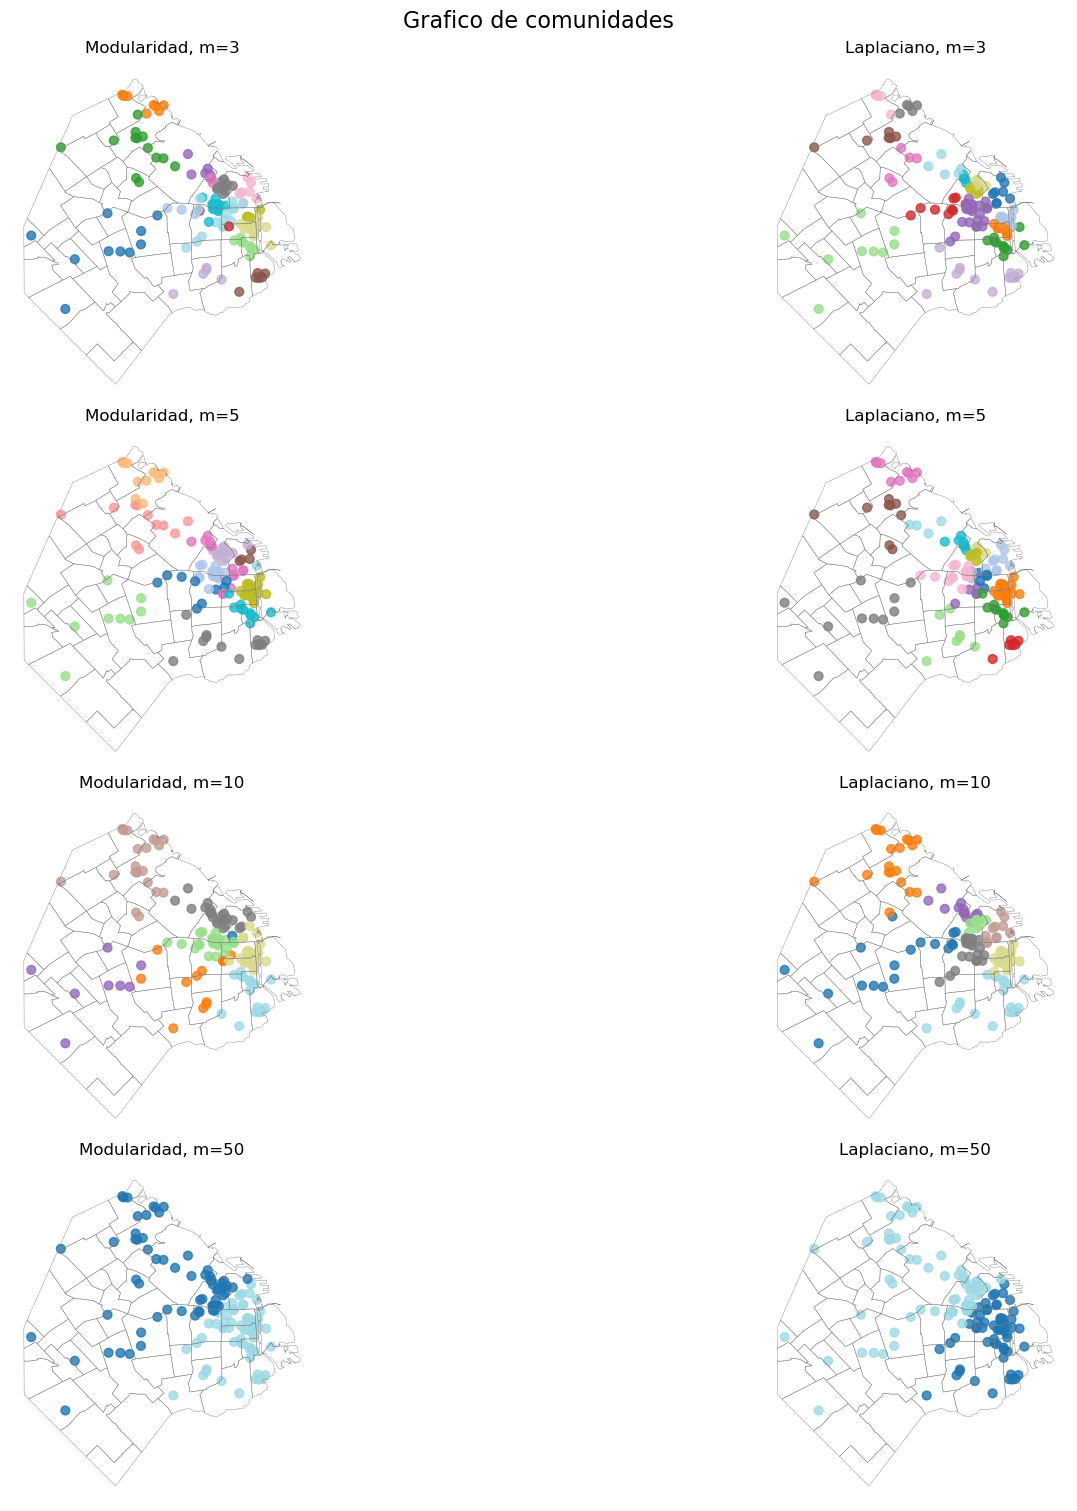

In [162]:
def crear_mapa_comunidades(comunidades, axs, titulo):

    # agregamos columna comunidad agregando a cual pertenece cada museo en cada iteracion
    labels = np.empty(len(museos), dtype=int)
    for i, comm in enumerate(comunidades):
        for nodo in comm:
            labels[nodo] = i
    museos['comunidad'] = labels

    # graficos en el axs del subplot
    barrios.boundary.plot(color='gray', linewidth=0.3, ax=axs)
    museos.plot(
        column='comunidad',
        cmap='tab20',
        categorical=True,
        markersize=40,
        alpha=0.8,
        legend=False,
        ax=axs
    )
    axs.set_title(titulo, pad=8)
    axs.set_axis_off()


# creamos la lista de m y el grid con subplots
lista_m = [3, 5, 10, 50]

fig, axes = plt.subplots(4, 2, figsize=(15, 15), constrained_layout=True)

for i in range(len(lista_m)):
    m = lista_m[i]

    np.random.seed(1234)  # reinicio el generador para que sea replicable

    A_sim = simetrizar(construye_adyacencia(D, m))

    # grafico las comunidades con Modularidad iterativo
    comunidades_mod = modularidad_iterativo(A_sim)
    crear_mapa_comunidades(comunidades_mod, axes[i, 0], titulo=f"Modularidad, m={m}")

    # grafico las comunidades con Laplaciano iterativo
    k_mod = len(comunidades_mod)  # número de comunidades encontradas

    niveles_lap = round(np.log2(k_mod))
    #Para que la comparación entre métodos sea significativa, se estimó la cantidad
    # de niveles n necesarios en el método laplaciano como n = round(log2(k)), donde k
    # es la cantidad de comunidades obtenidas por modularidad. Esto permite obtener un número comparable
    #de comunidades en ambos métodos, evitando que el método laplaciano genere particiones irrelevantes
    #o vacías debido a un exceso de niveles.

    comunidades_lap = laplaciano_iterativo(A_sim, niveles_lap)
    crear_mapa_comunidades(comunidades_lap, axes[i, 1], titulo=f"Laplaciano, m={m}")

    print(f"m = {m}")
    print(" ")
    print(f"nro de comunidades de modularidad: {k_mod}")
    print(f"nro de comunidades de laplaciano: {len(comunidades_lap)}")
    print("---------------------------------------")
    print(" ")
    print(" ")

fig.suptitle("Grafico de comunidades", fontsize=16)
plt.show()

Al observar la evolución de las comunidades generadas por los métodos de modularidad y laplaciano para distintos valores de m, se aprecian diferencias relevantes tanto en la cantidad de comunidades como en su distribución geográfica. Para valores bajos de m, ambos métodos detectan un mayor número de comunidades. Sin embargo, podemos captar enfoques distintos: la modularidad tiende a generar comunidades más compactas y con fuerte coherencia espacial, es decir, nodos que están cerca tienden a quedar agrupados. Por otro lado, el laplaciano presenta comunidades algo más dispersas, con nodos de una misma comunidad distribuidos en áreas menos continuas. Esto tiene sentido porque el método se basa en propiedades espectrales de la red y no tiene en cuenta directamente la cercanía geográfica entre los nodos, por lo que las comunidades pueden salir un poco menos ordenadas visualmente.

A medida que m aumenta, la red se densifica y ambos métodos comienzan a detectar menos comunidades, hasta llegar al caso de m = 50 donde solo se encuentran dos comunidades bien definidas. En este punto, las diferencias entre los métodos prácticamente desaparecen, y las particiones son muy similares tanto en número como en distribución. Un detalle a destacar es que, aunque los colores varíen, las agrupaciones son estructuralmente similares. Esto muestra que, si bien los métodos tienen enfoques distintos, en ciertos rangos de m logran capturar una estructura más consistente y coherente.

En resumen, los dos métodos funcionan bien pero con enfoques diferentes. La modularidad parece adaptarse mejor a la estructura geográfica cuando las conexiones son más locales, mientras que el laplaciano tiende a generar agrupaciones un poco más dispersas, sobre todo con m bajos. A medida que la red se vuelve más densa, las diferencias entre ambos se achican bastante y terminan detectando particiones muy parecidas.

Veamos ahora la estabilidad de los métodos. Para ello, utilizaremos tres semillas distintas y dos valores de m, uno bajo y uno alto.  
Comencemos con la modularidad:

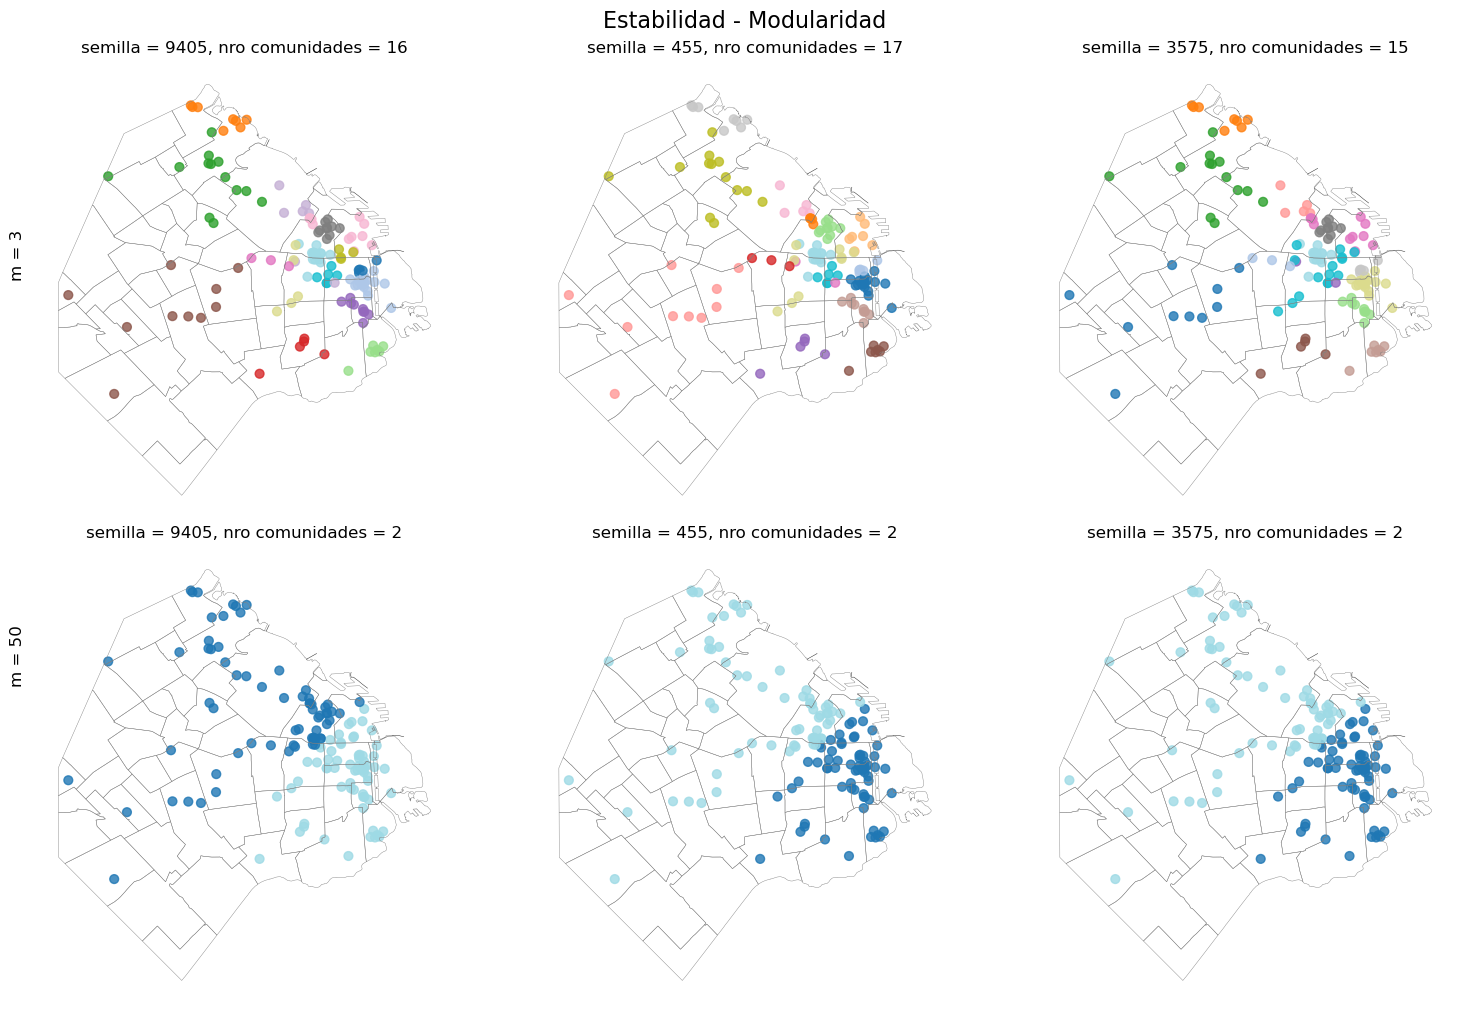

In [163]:
lista_m = [3, 50]
semillas = [random.randint(0, 10000) for _ in range(3)]

fig_mod, axes_mod = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

for i, m in enumerate(lista_m):
    for j, semilla in enumerate(semillas):
        np.random.seed(semilla)

        A_sim = simetrizar(construye_adyacencia(D, m))

        comunidades_mod = modularidad_iterativo(A_sim)
        crear_mapa_comunidades(comunidades_mod, axes_mod[i, j],
                               titulo=f"semilla = {semilla}, nro comunidades = {len(comunidades_mod)}")

    fig_mod.text(0.01, 0.75 - i*0.4, f"m = {m}", fontsize=12, va='center', ha='left', rotation=90)

fig_mod.suptitle("Estabilidad - Modularidad", fontsize=16)

plt.show()

Veamos qué pasa con m = 3:  
Luego de varias ejecuciones, observamos que la modularidad muestra una leve variación en la cantidad de comunidades (entre 14 y 19 según la semilla), lo cual indica cierta sensibilidad al azar. A pesar de esta variación, en los mapas se aprecia que la distribución espacial de las comunidades es bastante consistente: los grupos se ubican en regiones similares, tendiendo a formarse de manera compacta geográficamente. Esto sugiere que si bien el método es relativamente estable, pequeños cambios en la inicialización pueden afectar ligeramente la partición final.

m = 50:  
Por otro lado, para m = 50, el método es completamente estable: para las tres semillas detecta exactamente 2 comunidades, manteniendo una distribución muy similar en todos los casos. Esta estabilidad se explica porque con mayor conectividad, la red es más densa y las divisiones detectadas son más marcadas y consistentes.  

En resumen, el método de modularidad es bastante estable, especialmente cuando la red es más densa. Para valores bajos de m, puede haber pequeñas diferencias en el número de comunidades, pero la coherencia geográfica se mantiene.

Ahora veamos qué sucede con el laplaciano:

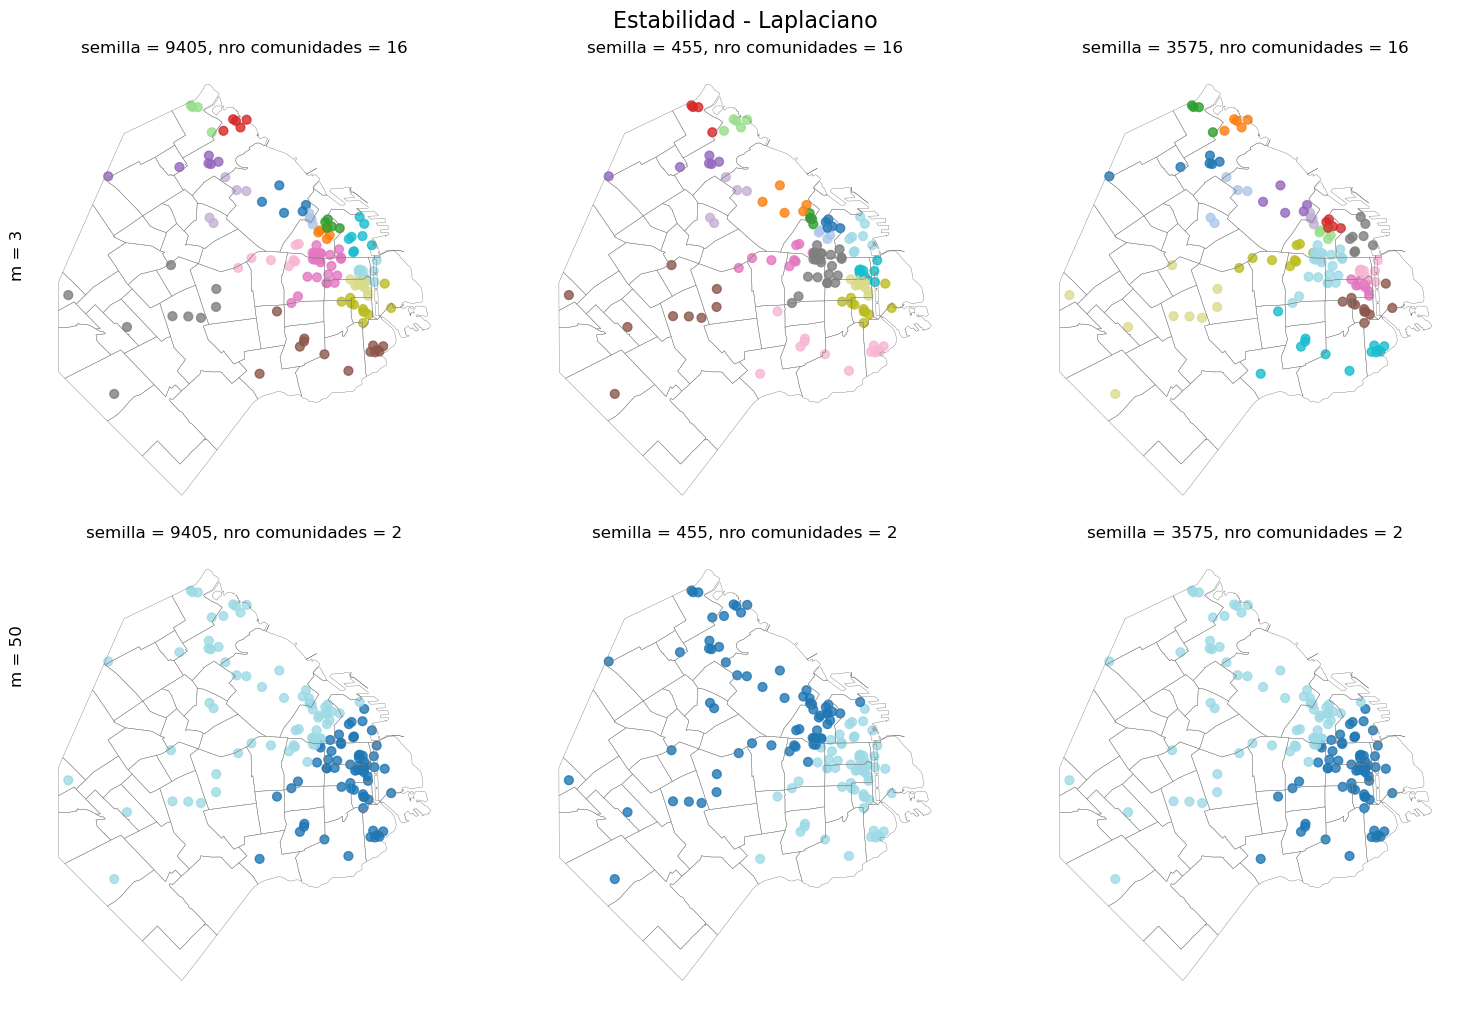

In [164]:
fig_lap, axes_lap = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

for i, m in enumerate(lista_m):
    for j, semilla in enumerate(semillas):
        np.random.seed(semilla)

        A_sim = simetrizar(construye_adyacencia(D, m))

        comunidades_mod = modularidad_iterativo(A_sim)

        k_mod = len(comunidades_mod)
        niveles_lap = round(np.log2(k_mod))
        comunidades_lap = laplaciano_iterativo(A_sim, niveles_lap)
        crear_mapa_comunidades(comunidades_lap, axes_lap[i, j],
                               titulo=f"semilla = {semilla}, nro comunidades = {len(comunidades_lap)}")

    fig_lap.text(0.01, 0.75 - i*0.4, f"m = {m}", fontsize=12, va='center', ha='left', rotation=90)

fig_lap.suptitle("Estabilidad - Laplaciano", fontsize=16)

plt.show()

Para el método laplaciano, ajustamos dinámicamente el número de niveles según la cantidad de comunidades obtenidas por modularidad, utilizando round(np.log2(k_mod)), lo que permitió estabilizar los resultados y evitar particiones demasiado finas. Esto último nos ocurría cuando utilizábamos la función ceil de la librería math en vez de round, causando que se generaran, para algunas semillas, 32 comunidades. Cambiando esto, logramos mantener más la estabilidad del método.  

Siguiendo la misma idea de comparación de la modularidad, notamos que para m = 3 el número de comunidades detectado por el laplaciano fue consistentemente 16 para distintas semillas en todas las ejecuciones. El método mostró así una mayor estabilidad en la cantidad de comunidades respecto a modularidad. También se mantiene una coherencia espacial en los mapas: las comunidades detectadas aparecen en zonas similares del mapa, aunque los colores asignados varíen por el orden aleatorio.  

Para m = 50, sucede lo mismo que con la modularidad: se detectaron exactamente 2 comunidades en todas las ejecuciones, independientemente de la semilla. Esto indica que cuando la red es más densa, los métodos se comportan de forma estable y coincidente, y detectan particiones robustas.

### Síntesis final
A lo largo de los Trabajos Prácticos 1 y 2 analizamos la red de museos de la Ciudad de Buenos Aires abordando distintas metodologías de análisis de redes para representar y estudiar las conexiones entre los museos.

En el primer TP comenzamos construyendo la red de museos a partir de los registros de visitas entre ellos con el objetivo de analizar cómo las personas podían recorrerlos durante La Noche de los Museos de CABA.  Aplicamos diversas métricas que nos permitieron identificar los museos más influyentes dentro del sistema y aplicamos el algoritmo de PageRank, que estima la probabilidad de llegar a cada museo luego de transitar la red durante cierto tiempo. Observamos que algunos museos presentaban altos valores en múltiples medidas, lo  puede significar que tiene una gran popularidad tanto como que tiene una buena conectividad con otros museos por cercanía. Otros comparten patrones de visitas similares, posiblemente influenciados por su ubicación o circuitos turísticos.

Durante este proceso, para hacerlo lo más abarcativo posible, exploramos cómo afectan distintos parámetros a los resultados de PageRank. Variamos el valor de m, que determina cuántos museos vecinos se conectan entre sí, observando que a medida que m aumenta, la red se vuelve más densa y los museos centrales ganan aún más relevancia. Por otro lado, al modificar el parámetro  α, vimos que recorridos más largos (α bajo) tienden a concentrar la importancia en zonas bien conectadas, mientras que α alto favorece una distribución más pareja.

En el segundo TP abordamos la detección de comunidades, empleando dos métodos iterativos basados en autovectores. El primero, a partir de la matriz laplaciana, busca minimizar el valor de lambda dividiendo la red en subconjuntos de nodos que presentan notables conexiones internas. El segundo, mediante la optimización de la modularidad, identifica particiones cuya densidad de conexiones internas es bastante elevada. Al comparar ambos métodos, ajustando los cortes para obtener cantidades similares de comunidades, observamos que si bien presentan diferencias, ambos logran segmentar la red en grupos coherentes.

Como conclusión, consideramos que los métodos de la segunda parte aportan una perspectiva complementaria al análisis inicial. Mientras que el TP1 nos permitió estimar la relevancia individual de cada museo dentro de los recorridos posibles, el TP2 nos brindó herramientas para entender cómo se organizan los grupos de museos dentro de la red. La conexión entre ambos enfoques resulta relevante en redes con pocas conexiones. Cuando m es bajo (red poco densa), observamos que los museos con mayor PageRank tienden a actuar como "puentes" entre diferentes comunidades detectadas en el TP2. Estos nodos centrales conectan grupos que de otro modo estarían aislados, explicando por qué concentran tanto flujo de visitantes. Por el contrario, cuando aumentamos m (red más densa), las comunidades se vuelven más unidas internamente, y el PageRank se distribuye de manera más homogénea dentro de cada grupo. En conjunto, entre las dos partes pudimos obtener una visión integral de circulación dentro de la red de museos.